In [79]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import numpy as np
import pandas as pd
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV
import matplotlib.pyplot as plt
import numpy as np

In [80]:
train_data = pd.read_csv('train.csv')

X = train_data.drop(columns=['data_ID', 'player_ID', 'gender', 'play years', 'hold racket handed', 'level'])

y_play_years = train_data['play years']
y_level = train_data['level']
y_gender = train_data['gender']
y_hold_racket_handed = train_data['hold racket handed']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train_play_years, X_val_play_years, y_train_play_years, y_val_play_years = train_test_split(X_scaled, y_play_years, test_size=0.2, random_state=42)
X_train_level, X_val_level, y_train_level, y_val_level = train_test_split(X_scaled, y_level, test_size=0.2, random_state=42)
X_train_gender, X_val_gender, y_train_gender, y_val_gender = train_test_split(X_scaled, y_gender, test_size=0.2, random_state=42)
X_train_hold, X_val_hold, y_train_hold, y_val_hold = train_test_split(X_scaled, y_hold_racket_handed, test_size=0.2, random_state=42)

test_data = pd.read_csv('test.csv')
X_test = test_data.drop(columns=['data_ID'])
X_test_scaled = scaler.transform(X_test)

[0.04048707 0.02352636 0.07705591 0.07468294 0.0417654  0.02871467
 0.02094617 0.01469453 0.04053754 0.05294092 0.03979508 0.02574818
 0.02696169 0.01716053 0.02672597 0.02094807 0.03551273 0.06687738
 0.0194328  0.05447454 0.00888243 0.04852666 0.07147833 0.00632554
 0.00817074 0.         0.00799238 0.         0.01133057 0.015982
 0.03954542 0.02310275 0.00967473 0.        ]


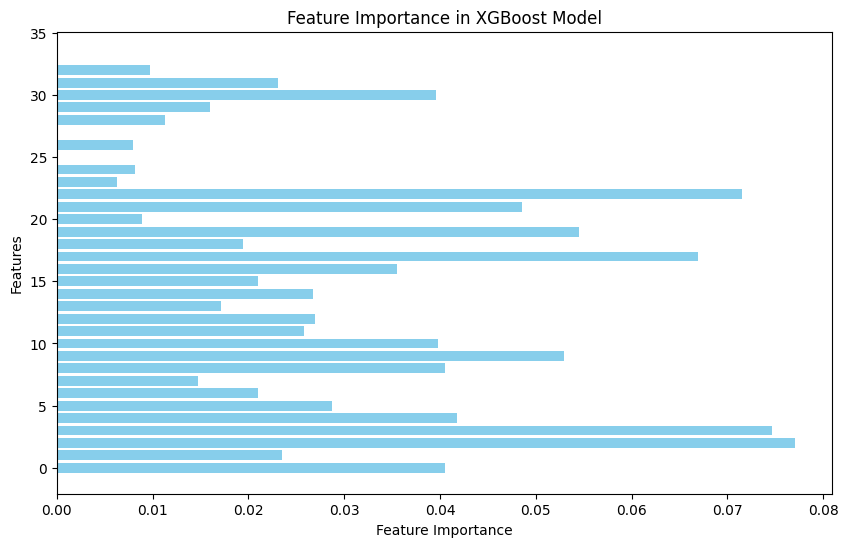

In [81]:
model = XGBClassifier()
model.fit(X_train_play_years, y_train_play_years)
feature_importances = model.feature_importances_
print(feature_importances)
# 假設特徵名稱存放在 features 中
features = X_train_play_years.columns if hasattr(X_train_play_years, 'columns') else np.arange(len(feature_importances))

# 繪製特徵重要性
plt.figure(figsize=(10, 6))
plt.barh(features, feature_importances, color='skyblue')
plt.xlabel("Feature Importance")
plt.ylabel("Features")
plt.title("Feature Importance in XGBoost Model")
plt.show()

In [ ]:
param_dist = {
}
other_params = {
    # ----通用參數----#
    'booster': 'gbtree',
    #'silent': 1, #不輸出
    'nthread': -1, #使用所有線程
    #------Booster參數---#
    'n_estimators': 500,
    'learning_rate': 0.07, #0.1就很好
    'gamma': 0.03, #上面側都是0
    'subsample': 0.7, #默認是1 
    'colsample_bytree': 0.8, #默認是1 一般設0.8 
    'colsample_bylevel': 1, #默認是1
    'max_depth': 9, #3-10 系統默認是6
    'max_delta_step': 0, #比較不會調 默認是0
    'reg_alpha': 0.01, #default 0
    'reg_lambda': 0.1, #default 0 ＃
    'min_child_weight': 2, #還沒測
    #----學習目標參數----#
    'objective': 'multi:softmax',
    'num_class': 3,
    'eval_metric': 'mlogloss',
    'seed': 42,        
    #'scale_pos_weight': 1
}
play_years_model = xgb.XGBClassifier(**other_params)
rserach = RandomizedSearchCV(
    estimator=play_years_model, 
    param_distributions=param_dist,
    n_iter=100,
    scoring='roc_auc_ovr',
    cv=3, 
    #verbose=1, 
    n_jobs=-1
)
rserach.fit(X_train_play_years, y_train_play_years)
#gserach.grid_scores_
#'n_estimators': [300, 400, 500, 600, 700, 800]
#'gamma': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6]
#'max_depth': [3, 4, 5, 6, 7, 8, 9, 10], 'min_child_weight': [1, 2, 3, 4, 5, 6]
#'subsample': [0.6, 0.7, 0.8, 0.9], 'colsample_bytree': [0.6, 0.7, 0.8, 0.9]
#'reg_alpha':[1e-5, 1e-2, 0.05, 0.1, 1, 2, 3]
#'reg_lambda': [0.05, 0.1, 0.2, 0.4, 0.6, 0.8, 1, 2, 3]
#"eta/learning_rate": [0.01, 0.02, 0.05, 0.07, 0.08, 0.1, 0.12, 0.15, 0.2, 0.3]

/home/charles/miniconda3/envs/tokyo/lib/python3.13/site-packages/sklearn/model_selection/_search.py:320: UserWarning: The total space of parameters 6 is smaller than n_iter=100. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


"\n    'booster':'gbtree',\n    'objective':'multi:softmax',\n    'num_class':3,\n    'n_estimators': 1100,\n    #'eval_metric': 'merror'\n    'max_depth': 9, #3-10\n    'min_child_weight': 3, \n    'seed': 42,       \n    'gamma': 0,\n    'subsample': 0.8, \n    'colsample_bytree': 0.85, \n    'learning_rate': 0.1,\n    'reg_alpha': 0, \n    'reg_lambda': 0.01,\n    #silent default = 0\n    'nthread': -1,\n    'eta': 0.1\n    #'scale_pos_weight': 1\n"

In [40]:
print('Years参数的最佳取值：{0}'.format(rserach.best_params_))
print('Years最佳模型得分:{0}'.format(rserach.best_score_))
#Years参数的最佳取值：{'subsample': 0.7, 'n_estimators': 500, 'max_depth': 9, 'learning_rate': 0.07, 'eval_metric': 'mlogloss', 'colsample_bytree': 0.8}
#Years最佳模型得分:0.9911615196398298

Years参数的最佳取值：{'reg_lambda': 0.1, 'reg_alpha': 0.01, 'gamma': 0.03}
Years最佳模型得分:0.9900194826134592


In [62]:
play_years_model = xgb.XGBClassifier(
    #booster = 'gbtree',
    objective = 'multi:softprob',
    num_class = 3,
    #n_estimators = 500,
    eval_metric = 'mlogloss',
    #max_depth = 9, #3-10
    #min_child_weight = 2, 
    #seed = 42,       
    #gamma = 0.03,
    #subsample = 0.7, 
    #colsample_bytree = 0.8, 
    #learning_rate = 0.07,
    #reg_alpha = 0.01, 
    #reg_lambda = 0.1,
    #silent default = 0
    nthread = -1,
    #eta = 0.1,
    #verbose = 1, 
    n_jobs = -1,
)
play_years_model.fit(X_train_play_years, y_train_play_years)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=-1, nthread=-1, num_class=3, ...)

In [ ]:
param_dist = {}
other_params = {
     # ----通用參數----#
    'booster': 'gbtree',
    #'silent': 1, #不輸出
    'nthread': -1, #使用所有線程
    #------Booster參數---#
    'n_estimators': 325,
    'learning_rate': 0.1395, #0.1就很好
    'gamma': 0.125, #上面側都是0
    'subsample': 0.69, #默認是1 
    'colsample_bytree': 0.83, #默認是1 一般設0.8 
    'colsample_bylevel': 1, #默認是1
    'max_depth': 7, #3-10 系統默認是6
    'max_delta_step': 0, #比較不會調 默認是0
    'reg_alpha': 0.082, #default 0
    'reg_lambda': 0.4, #default 0 ＃
    'min_child_weight': 6.35, #還沒測
    #----學習目標參數----#
    'objective': 'multi:softprob',
    'num_class': 3,
    #'eval_metric': 'error'
    'seed': 7,        
    #'scale_pos_weight': 1
}

level_model = xgb.XGBClassifier(**other_params)
rserach = RandomizedSearchCV(
    estimator=level_model, 
    param_distributions=param_dist, 
    n_iter=100,
    scoring='neg_log_loss',
    cv=5, 
    verbose=1, 
    n_jobs=-1
)
rserach.fit(X_train_level, y_train_level)
#'n_estimators': [300, 400, 500, 600, 700, 800]
#'gamma': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6]
#'max_depth': [3, 4, 5, 6, 7, 8, 9, 10], 'min_child_weight': [1, 2, 3, 4, 5, 6]
#'subsample': [0.6, 0.7, 0.8, 0.9], 'colsample_bytree': [0.6, 0.7, 0.8, 0.9]
#'reg_alpha':[1e-5, 1e-2, 0.05, 0.1, 1, 2, 3]
#'reg_lambda': [0.05, 0.1, 0.2, 0.4, 0.6, 0.8, 1, 2, 3]
#"eta/learning_rate": [0.01, 0.02, 0.05, 0.07, 0.08, 0.1, 0.12, 0.15, 0.2, 0.3]

/home/charles/miniconda3/envs/tokyo/lib/python3.13/site-packages/sklearn/model_selection/_search.py:320: UserWarning: The total space of parameters 36 is smaller than n_iter=100. Running 36 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 5 folds for each of 36 candidates, totalling 180 fits


RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster='gbtree',
                                           callbacks=None, colsample_bylevel=1,
                                           colsample_bynode=None,
                                           colsample_bytree=0.83, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=0.125, grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_ra...
                                           max_delta_step=0, max_depth=7,
                                           max_leaves=None,
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           multi_strategy=None,
                                           n_estimators=325, n_jobs=None,
                                           nthread=-1, num_class=3, ...),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'learning_rate': [0.1393, 0.1395,
                                                          0.1397],
                                        'min_child_weight': [6, 33, 6.35, 6.37],
                                        'reg_alpha': [0.0815, 0.082, 0.0825]},
                   scoring='neg_log_loss', verbose=1)

In [41]:
print('Level参数的最佳取值：{0}'.format(rserach.best_params_))
print('Level最佳模型得分:{0}'.format(rserach.best_score_))
#Level最佳模型得分:-0.13552197460134835

Level参数的最佳取值：{'reg_alpha': 0.082, 'min_child_weight': 6, 'learning_rate': 0.1395}
Level最佳模型得分:-0.13552197460134835


In [63]:
level_model = xgb.XGBClassifier(
    #booster = 'gbtree',
    objective = 'multi:softprob',
    num_class = 3,
    #n_estimators = 325,
    eval_metric = 'mlogloss',
    #max_depth = 7, #3-10
    #min_child_weight = 6.35, 
    seed = 42,       
    #gamma = 0.125,
    #subsample = 0.69, 
    #colsample_bytree = 0.83, 
    #learning_rate = 0.1395,
    #reg_alpha = 0.082, 
    #reg_lambda = 0.4,
    #silent = 1,
    nthread = -1,
    #eta = 0.1,
    #verbose = 2, 
    n_jobs = -1
)
level_model.fit(X_train_level, y_train_level)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=-1, nthread=-1, num_class=3, ...)

In [64]:
y_val_prob_play_years = play_years_model.predict_proba(X_val_play_years)
play_years_log_loss = -1 * roc_auc_score(y_val_play_years, y_val_prob_play_years, multi_class='ovr')
print(f'Play Years Validation Log Loss: {play_years_log_loss:.4f}')

y_val_prob_level = level_model.predict_proba(X_val_level)
level_log_loss = -1 * roc_auc_score(y_val_level, y_val_prob_level, multi_class='ovr')
print(f'Level Validation Log Loss: {level_log_loss:.4f}')

Play Years Validation Log Loss: -0.9890
Level Validation Log Loss: -0.9914


In [69]:
# 使用模型進行測試集預測
play_years_test_probabilities = play_years_model.predict_proba(X_test_scaled)
level_test_probabilities = level_model.predict_proba(X_test_scaled)

print(play_years_test_probabilities)
print(level_test_probabilities)

[[8.7445641e-01 6.4482734e-02 6.1060868e-02]
 [9.9904758e-01 7.3297479e-04 2.1949311e-04]
 [9.6785486e-01 2.7879115e-02 4.2659957e-03]
 ...
 [9.9861264e-01 1.3381016e-03 4.9277223e-05]
 [9.9817896e-01 1.7159309e-03 1.0515637e-04]
 [9.9435037e-01 5.5510113e-03 9.8607787e-05]]
[[8.7950325e-01 1.9522116e-02 1.0097465e-01]
 [1.9324262e-02 4.6675559e-03 9.7600818e-01]
 [1.4996564e-02 1.7890816e-04 9.8482448e-01]
 ...
 [1.3933041e-03 4.5627727e-05 9.9856108e-01]
 [2.2220746e-02 3.8146109e-03 9.7396457e-01]
 [1.4719534e-02 9.0284488e-04 9.8437762e-01]]


In [ ]:
param_dist = {
    'n_estimators': [423, 424, 425, 436, 427],
    'gamma': [0.133, 0.13, 0.135],
    'max_depth': [8, 9, 10], 
    'min_child_weight': [3.05, 3.1, 3.15],
    'subsample': [0.72, 0.725, 0.73], 
    'colsample_bytree': [0.79, 0.8, 0.81],
    'reg_alpha':[0.025, 0.03, 0.035],
    'reg_lambda': [0.43, 0.44, 0.45, 0.46, 0.470],
    "learning_rate": [0.073, 0.075, 0.077]
}
other_params = {
    # ----通用參數----#
    'booster': 'gbtree',
    #'silent': 1, #不輸出
    'nthread': -1, #使用所有線
    #------Booster參數---#
    'n_estimators': 427,
    'learning_rate': 0.075, #0.1就很好
    'gamma': 0.13, #上面側都是0
    'subsample': 0.73, #默認是1 
    'colsample_bytree': 0.81, #默認是1 一般設0.8 
    'colsample_bylevel': 1, #默認是1
    'max_depth': 9, #3-10 系統默認是6
    'max_delta_step': 0, #比較不會調 默認是0
    'reg_alpha': 0.035, #default 0
    'reg_lambda': 0.45, #default 0 ＃
    'min_child_weight': 3.05, #還沒測
    #----學習目標參數----#
    #'objective': 'multi:softmax',
    #'num_class': 2,
    #'eval_metric': 'error'
    'seed': 1,        
    #verbose = 1, 
    #'n_jobs': -1 #默認是1 使用多少個線性並行構建
}

gender_model = xgb.XGBClassifier(**other_params)
rserach = RandomizedSearchCV(
    estimator=gender_model, 
    param_distributions=param_dist, 
    n_iter=100,
    scoring='roc_auc',
    cv=5, 
    #verbose=1, 
    n_jobs=-1
)
rserach.fit(X_train_gender, y_train_gender)
#'n_estimators': [300, 400, 500, 600, 700, 800]
#'gamma': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6]
#'max_depth': [3, 4, 5, 6, 7, 8, 9, 10], 'min_child_weight': [1, 2, 3, 4, 5, 6]
#'subsample': [0.6, 0.7, 0.8, 0.9], 'colsample_bytree': [0.6, 0.7, 0.8, 0.9]
#'reg_alpha':[1e-5, 1e-2, 0.05, 0.1, 1, 2, 3]
#'reg_lambda': [0.05, 0.1, 0.2, 0.4, 0.6, 0.8, 1, 2, 3]
#"eta/learning_rate": [0.01, 0.02, 0.05, 0.07, 0.08, 0.1, 0.12, 0.15, 0.2, 0.3]

RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster='gbtree',
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_...
                   n_iter=100, n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.79, 0.8, 0.81],
                                        'gamma': [0.133, 0.13, 0.135],
                                        'learning_rate': [0.073, 0.075, 0.077],
                                        'max_depth': [8, 9, 10],
                                        'min_child_weight': [3.05, 3.1, 3.15],
                                        'n_estimators': [423, 424, 425, 436,
                                                         427],
                                        'reg_alpha': [0.025, 0.03, 0.035],
                                        'reg_lambda': [0.43, 0.44, 0.45, 0.46,
                                                       0.47],
                                        'subsample': [0.72, 0.725, 0.73]},
                   scoring='roc_auc')

In [11]:
print('Gender参数的最佳取值：{0}'.format(rserach.best_params_))
print('Gender最佳模型得分:{0}'.format(rserach.best_score_))

Gender参数的最佳取值：{'subsample': 0.73, 'reg_lambda': 0.45, 'reg_alpha': 0.035, 'n_estimators': 427, 'min_child_weight': 3.05, 'max_depth': 9, 'learning_rate': 0.075, 'gamma': 0.13, 'colsample_bytree': 0.81}
Gender最佳模型得分:0.9946539476521105


In [ ]:
param_dist = {
    'n_estimators': [1 200, 300, 400, 500],
    'max_depth': [3, 4, 5, 6, 7, 8, 9, 10], 
    'min_child_weight': [1, 2, 3, 4, 5, 6],
    'gamma': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6],
    'subsample': [0.6, 0.7, 0.8, 0.9], 
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9],
    'reg_alpha':[1e-5, 1e-2, 0.05, 0.1, 1, 2, 3],
    'reg_lambda': [0.05, 0.1, 0.2, 0.4, 0.6, 0.8, 1, 2, 3],
    "learning_rate": [0.01, 0.02, 0.05, 0.07, 0.08, 0.1, 0.12, 0.15, 0.2, 0.3]
}
other_params = {
    # ----通用參數----#
    'booster': 'gbtree',
    #'silent': 1, #不輸出
    'nthread': -1, #使用所有線
    #------Booster參數---#
    #'n_estimators': 200,
    #'learning_rate': 0.07, #0.1就很好
    #'gamma': 0.2, #上面側都是0
    #'subsample': 0.7, #默認是1 
    #'colsample_bytree': 0.7, #默認是1 一般設0.8 
    #'colsample_bylevel': 1, #默認是1
    #'max_depth': 7, #3-10 系統默認是6
    'max_delta_step': 0, #比較不會調 默認是0
    #'reg_alpha': 0.01, #default 0
    #'reg_lambda': 0.8, #default 0 ＃
    #'min_child_weight': 2, #還沒測
    #----學習目標參數----#
    #'objective': 'multi:softmax',
    #'num_class': 2,
    #'eval_metric': 'error'
    'seed': 2,        
    #verbose = 1, 
    #'n_jobs': -1 #默認是1 使用多少個線性並行構建
}

Hold_model = xgb.XGBClassifier(**other_params)
rserach = RandomizedSearchCV(
    estimator=Hold_model, 
    param_distributions=param_dist, 
    n_iter=100,
    scoring='roc_auc',
    cv=5, 
    #verbose=1, 
    n_jobs=-1
)
rserach.fit(X_train_hold, y_train_hold)
#'n_estimators': [300, 400, 500, 600, 700, 800]
#'max_depth': [3, 4, 5, 6, 7, 8, 9, 10], 'min_child_weight': [1, 2, 3, 4, 5, 6]
#'gamma': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6]
#'subsample': [0.6, 0.7, 0.8, 0.9], 'colsample_bytree': [0.6, 0.7, 0.8, 0.9]
#'reg_alpha':[1e-5, 1e-2, 0.05, 0.1, 1, 2, 3]
#'reg_lambda': [0.05, 0.1, 0.2, 0.4, 0.6, 0.8, 1, 2, 3]
#"eta/learning_rate": [0.01, 0.02, 0.05, 0.07, 0.08, 0.1, 0.12, 0.15, 0.2, 0.3]


RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster='gbtree',
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_...
                   param_distributions={'colsample_bytree': [0.6, 0.7, 0.8,
                                                             0.9],
                                        'gamma': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6],
                                        'learning_rate': [0.01, 0.02, 0.05,
                                                          0.07, 0.08, 0.1, 0.12,
                                                          0.15, 0.2, 0.3],
                                        'max_depth': [3, 4, 5, 6, 7, 8, 9, 10],
                                        'min_child_weight': [1, 2, 3, 4, 5, 6],
                                        'n_estimators': [100, 200, 300, 400,
                                                         500],
                                        'reg_alpha': [1e-05, 0.01, 0.05, 0.1, 1,
                                                      2, 3],
                                        'reg_lambda': [0.05, 0.1, 0.2, 0.4, 0.6,
                                                       0.8, 1, 2, 3],
                                        'subsample': [0.6, 0.7, 0.8, 0.9]},
                   scoring='roc_auc')

In [13]:
print('Hold参数的最佳取值：{0}'.format(rserach.best_params_))
print('Hold最佳模型得分:{0}'.format(rserach.best_score_))

Hold参数的最佳取值：{'subsample': 0.7, 'reg_lambda': 0.8, 'reg_alpha': 0.01, 'n_estimators': 200, 'min_child_weight': 2, 'max_depth': 7, 'learning_rate': 0.07, 'gamma': 0.2, 'colsample_bytree': 0.7}
Hold最佳模型得分:0.9997888293481744


In [72]:
gender_model = xgb.XGBClassifier(
    # ----通用參數----#
    #booster = 'gbtree',
    #silent = 1, #不輸出
    nthread = -1, #使用所有線程
    #------Booster參數---#
    #n_estimators = 427, #還沒測
    #learning_rate = 0.075, #0.1就很好
    #gamma = 0.13, #上面側都是0
    #subsample = 0.73, #默認是1 還沒測
    #colsample_bytree = 0.81, #默認是1 一般設0.8 還沒測 
    #colsample_bylevel = 1, #默認是1
    #max_depth = 9, #3-10 系統默認是6
    #max_delta_step = 0, #比較不會調 默認是0
    #reg_alpha = 0.035, #default 0
    #reg_lambda = 0.45, #default 0 ＃還沒測
    #min_child_weight = 3.05, #還沒測
    #----學習目標參數----#
    objective = 'binary:logistic',
    #num_class = 2,
    eval_metric = 'auc',
    seed = 7,        
    #verbose = 1, 
    n_jobs = -1 #默認是1 使用多少個線性並行構建
)
gender_model.fit(X_train_gender, y_train_gender)
hold_model = xgb.XGBClassifier(
   # ----通用參數----#
    #booster = 'gbtree',
    nthread = -1, #使用所有線程
    #------Booster參數---#
    #n_estimators = 200, #還沒測
    #learning_rate = 0.07, #0.1就很好
    #gamma = 0.2, #上面側都是0
    #subsample = 0.7, #默認是1 還沒測
    #colsample_bytree = 0.7, #默認是1 一般設0.8 還沒測 
    #colsample_bylevel = 1, #默認是1
    #max_depth = 7, #3-10 系統默認是6
    #max_delta_step = 0, #比較不會調 默認是0
    #reg_alpha = 0.01, #default 0
    #reg_lambda = 0.8, #default 0 ＃還沒測
    #min_child_weight = 2, #還沒測
    #----學習目標參數----#
    objective = 'binary:logistic',
    #num_class = 2,
    eval_metric = 'auc',
    seed = 2,        
    #verbose = 1, 
    n_jobs = -1 #默認是1 使用多少個線性並行構建
)
hold_model.fit(X_train_hold, y_train_hold)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=-1, nthread=-1,
              num_parallel_tree=None, ...)

In [75]:
# 使用模型進行驗證集預測
y_val_pred_gender = gender_model.predict(X_val_gender)
y_val_prob_gender = gender_model.predict_proba(X_val_gender)[:, 1]

# 計算 `gender` 的準確率和 ROC AUC 分數
gender_accuracy = accuracy_score(y_val_gender, y_val_pred_gender)
gender_roc_auc = roc_auc_score(y_val_gender, y_val_prob_gender)
print(f'Gender Prediction Validation Accuracy: {gender_accuracy * 100:.2f}%')
print(f'Gender Prediction ROC AUC Score: {gender_roc_auc:.4f}')

# 使用模型進行驗證集預測
y_val_pred_hold = hold_model.predict(X_val_hold)
y_val_prob_hold = hold_model.predict_proba(X_val_hold)[:, 1]

# 計算 `hold racket handed` 的準確率和 ROC AUC 分數
hold_accuracy = accuracy_score(y_val_hold, y_val_pred_hold)
hold_roc_auc = roc_auc_score(y_val_hold, y_val_prob_hold)
print(f'Hold Racket Handed Prediction Validation Accuracy: {hold_accuracy * 100:.2f}%')
print(f'Hold Racket Handed Prediction ROC AUC Score: {hold_roc_auc:.4f}')

Gender Prediction Validation Accuracy: 97.04%
Gender Prediction ROC AUC Score: 0.9922
Hold Racket Handed Prediction Validation Accuracy: 99.62%
Hold Racket Handed Prediction ROC AUC Score: 0.9998


In [76]:
# Gender 和 Hold Racket Handed 的二元預測
y_test_pred_gender = gender_model.predict(X_test_scaled)
y_test_pred_hold = hold_model.predict(X_test_scaled)

In [78]:
y_pred = gender_model.predict(X_test_scaled)
y_pred_hold = hold_model.predict(X_test_scaled)

test_submission = pd.DataFrame({
    'data_ID': test_data['data_ID'],
    'gender': y_pred,
    'hold racket handed': y_pred_hold,
    'play years_0': play_years_test_probabilities[:, 0],
    'play years_1': play_years_test_probabilities[:, 1],
    'play years_2': play_years_test_probabilities[:, 2],
    'level_0': level_test_probabilities[:, 0],
    'level_1': level_test_probabilities[:, 1],
    'level_2': level_test_probabilities[:, 2]
})
test_submission.to_csv('test_predictions2.csv', index=False)